<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model and Evaluation
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics

# statsmodel
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [2]:
hourly_data = pd.read_csv('../data/interim/hourly_data.csv')
hourly_data.head()

,rental_date,rental_hour,rental_day,rental_year,holiday,dayofweek_n,dayofweek,working_day,season,peak,timesofday,rain,temp,rhum,wdsp,count
0,2021-02-01,6,1,2021,False,0,Monday,True,Winter,True,Night,0.0,3.4,98,3,1
1,2021-02-01,8,1,2021,False,0,Monday,True,Winter,True,Morning,0.0,3.5,93,4,2
2,2021-02-01,9,1,2021,False,0,Monday,True,Winter,True,Morning,0.0,2.6,93,2,4
3,2021-02-01,10,1,2021,False,0,Monday,True,Winter,True,Morning,0.0,4.1,97,4,3
4,2021-02-01,11,1,2021,False,0,Monday,True,Winter,False,Morning,0.0,5.2,86,6,12


## Testing Linear Regression Assumptions

In [6]:
hourlyDataWithoutOutliers = hourly_data[np.abs(hourly_data["count"]-hourly_data["count"].mean())<=(2*hourly_data["count"].std())] 

df = hourly_data.copy()
#df = hourlyDataWithoutOutliers.copy()
df = df.astype({'holiday': 'category', 
                'dayofweek': 'category', 
                'working_day': 'category',
                'rental_hour': 'category',
                'peak': 'category', 
                'timesofday': 'category'})
predictors = ['rain','temp','wdsp','rhum','holiday','dayofweek','working_day','peak','timesofday']

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')
num_vars = [n for n in df.select_dtypes(include=['number']).columns if n in predictors] # list comprehension to select only predictors features
cat_vars = [c for c in df.select_dtypes(include=['category']).columns if c in predictors]

dummies = pd.get_dummies(X[cat_vars], drop_first=True)
X = pd.concat([X[num_vars], dummies],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((5212, 16), (2235, 16))

In [57]:
X_with_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_with_constant)
results = model.fit()
results.params

const    8.975768
temp     0.111929
rhum    -0.072300
dtype: float64

In [58]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     499.5
Date:                Sun, 03 Apr 2022   Prob (F-statistic):          2.55e-198
Time:                        18:23:09   Log-Likelihood:                -11579.
No. Observations:                4946   AIC:                         2.316e+04
Df Residuals:                    4943   BIC:                         2.318e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9758      0.296     30.273      0.0

In [7]:
def adjusted_r2_score(X, r2_score):
    return 1 - ( 1- r2_score ) * ( len(X) - 1 ) / ( len(X) - X.shape[1] - 1 )

In [8]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [16]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    print('If non-linearity is apparent, consider adding a polynomial term')

In [11]:
X_train.head()

,rain,temp,rhum,wdsp,holiday_True,dayofweek_Monday,dayofweek_Saturday,dayofweek_Sunday,dayofweek_Thursday,dayofweek_Tuesday,dayofweek_Wednesday,working_day_True,peak_True,timesofday_Evening,timesofday_Morning,timesofday_Night
6424,0.0,4.0,92,8,0,0,0,0,0,0,0,1,0,1,0,0
7435,0.0,7.6,80,16,0,0,0,1,0,0,0,0,0,0,1,0
2851,0.0,12.5,94,5,0,0,0,0,0,0,1,1,0,0,0,1
272,0.0,7.6,66,12,0,0,0,0,0,0,1,1,1,0,1,0
2042,0.0,13.2,63,7,0,0,0,0,0,0,1,1,1,1,0,0


In [12]:

# Fitting the model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Returning the R^2 for the model
linear_model_r2 = linear_model.score(X_train, y_train)
print('R^2: {0}'.format(linear_model_r2))

R^2: 0.2638668912786196


Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


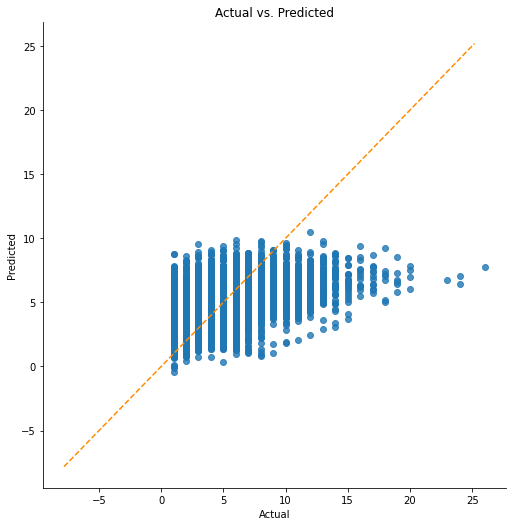

If non-linearity is apparent, consider adding a polynomial term


In [17]:
linear_assumption(linear_model, X_train, y_train)

In [29]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 5)
X_poly = poly.fit_transform(X_train) 
# poly.fit(X_poly, y_train)
lin2 = LinearRegression()
lin2.fit(X_poly, y_train)

LinearRegression()

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


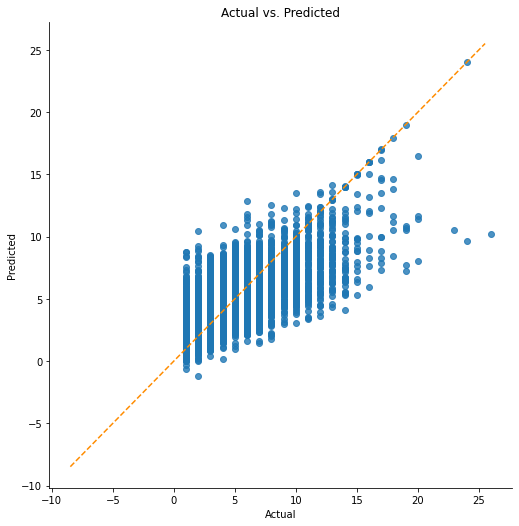

If non-linearity is apparent, consider adding a polynomial term


In [30]:
linear_assumption(lin2, X_poly, y_train)

In [17]:
X_test = sm.add_constant(X_test)
y_pred = results.predict(X_test)
residual = y_test - y_pred

In [18]:
# Multicolinearity
vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

,rain,temp,rhum,wdsp
vif,1.042173,4.26324,7.027267,4.164995


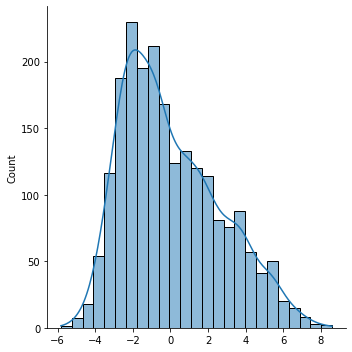

In [19]:
ax = sns.displot(residual, kde=True)

0.045740045564675334

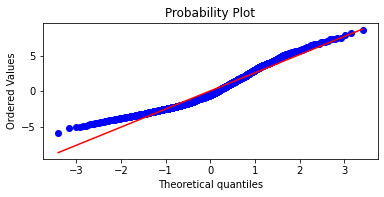

In [23]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
np.mean(residual)

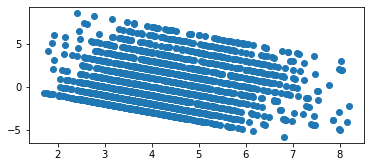

In [24]:
fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_pred, residual)

<Figure size 1584x432 with 0 Axes>

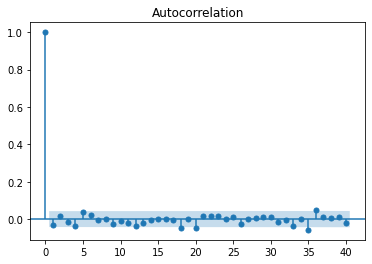

In [25]:
fig = plt.figure(figsize=(22,6))
acf = smt.graphics.plot_acf(residual, lags=40 , alpha=0.05)
plt.show()

## Feature Transformation

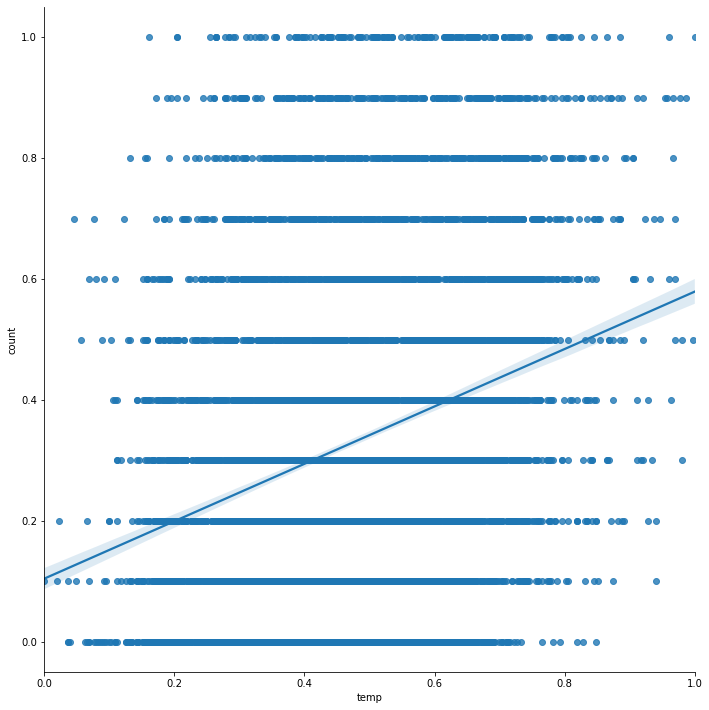

In [88]:
from random import sample
hourlyDataWithoutOutliers = hourly_data[np.abs(hourly_data["count"]-hourly_data["count"].mean())<=(2*hourly_data["count"].std())] 
df_percent = hourlyDataWithoutOutliers.sample(frac=0.5)
normalized_numerical_data = hourlyDataWithoutOutliers.filter(['temp','rain','wdsp','rhum','count'], axis=1)
scaled_features = MinMaxScaler().fit_transform(normalized_numerical_data.values)
scaled_features_df = pd.DataFrame(scaled_features, index=normalized_numerical_data.index, columns=normalized_numerical_data.columns)
sns.pairplot(scaled_features_df, 
             x_vars=['temp'],
            #  x_vars=['temp','rain','wdsp','rhum'],
             dropna=True, 
             y_vars='count', height=10, kind="reg", palette='Set1')
plt.show()

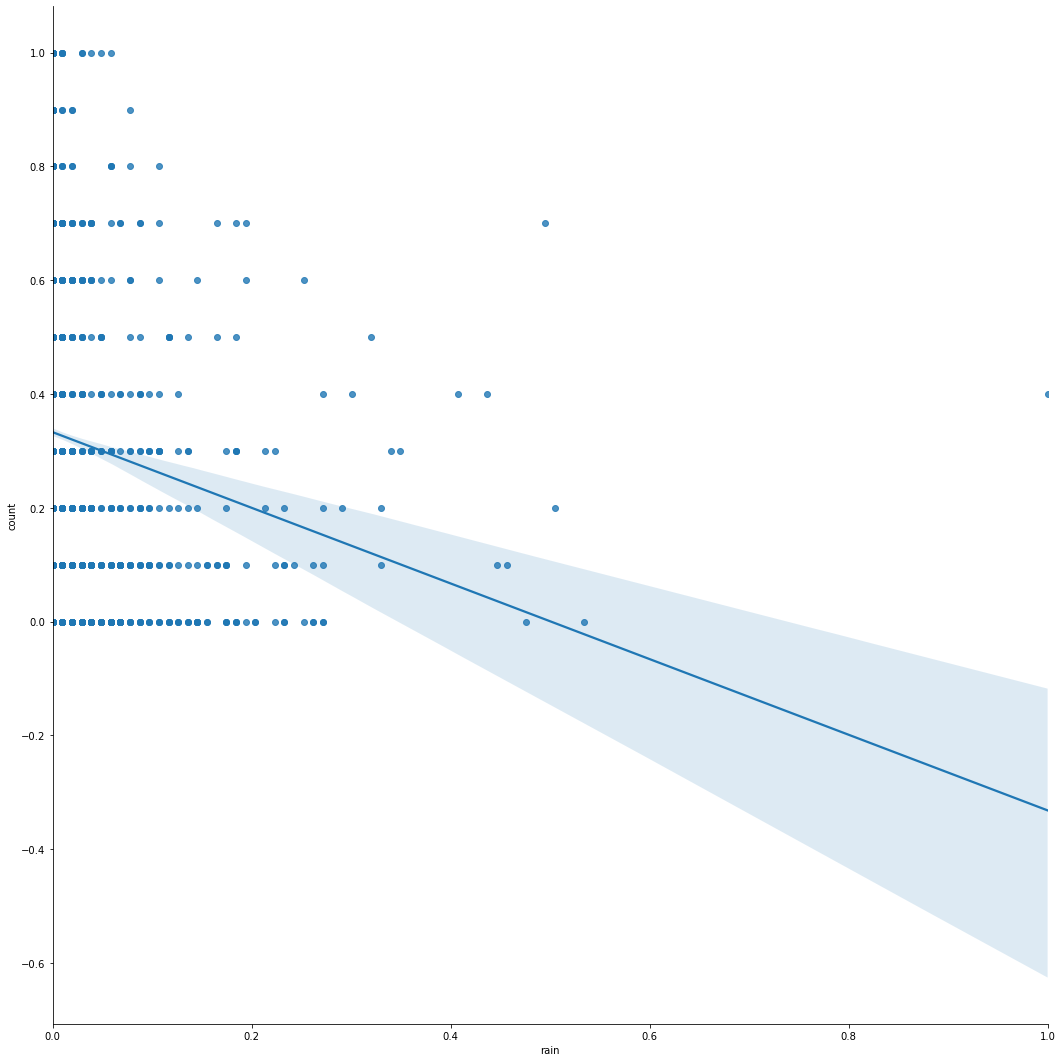

In [90]:
sns.pairplot(scaled_features_df, 
             x_vars=['rain'],
            #  x_vars=['temp','rain','wdsp','rhum'],
             dropna=True, 
             y_vars='count', height=15, kind="reg", palette='Set1')
plt.show()

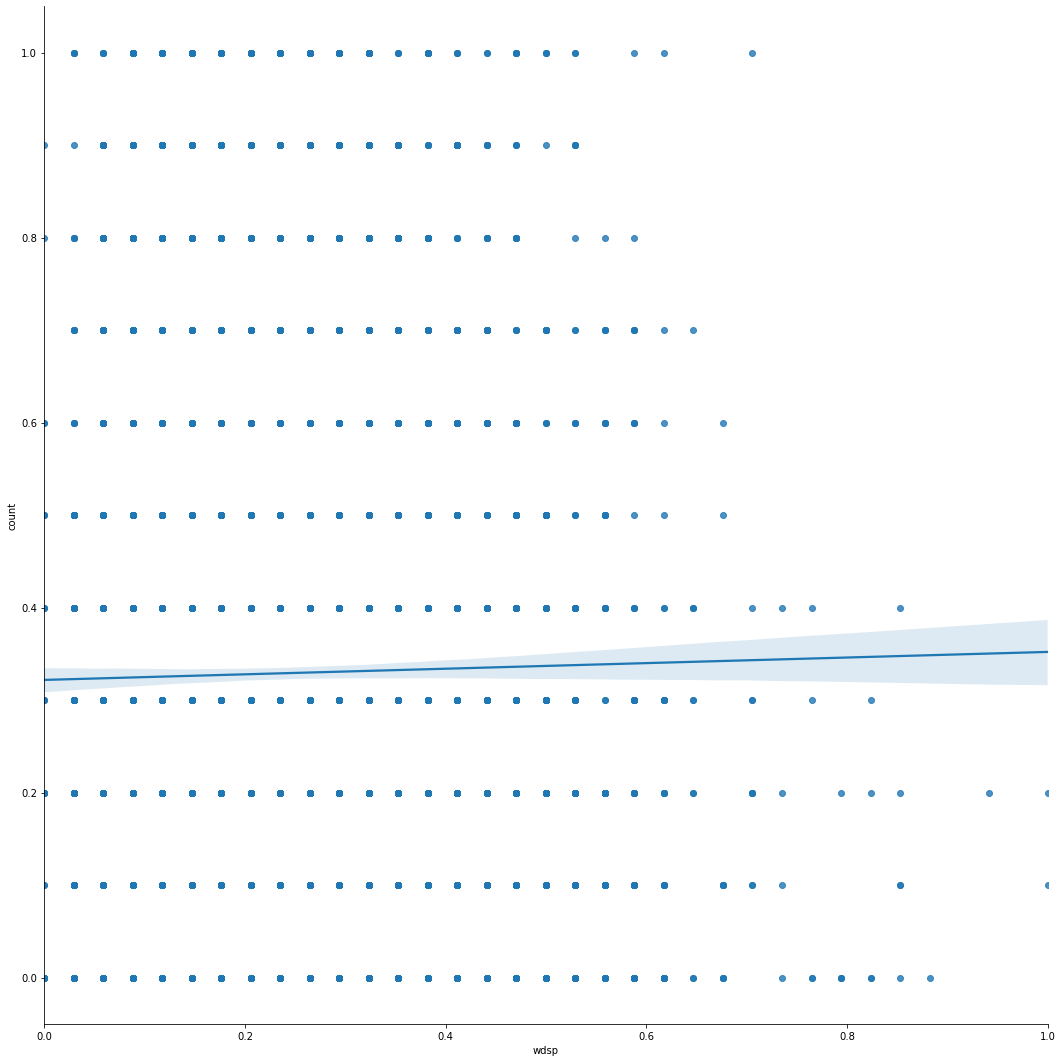

In [91]:
sns.pairplot(scaled_features_df, 
             x_vars=['wdsp'],
            #  x_vars=['temp','rain','wdsp','rhum'],
             dropna=True, 
             y_vars='count', height=15, kind="reg", palette='Set1')
plt.show()

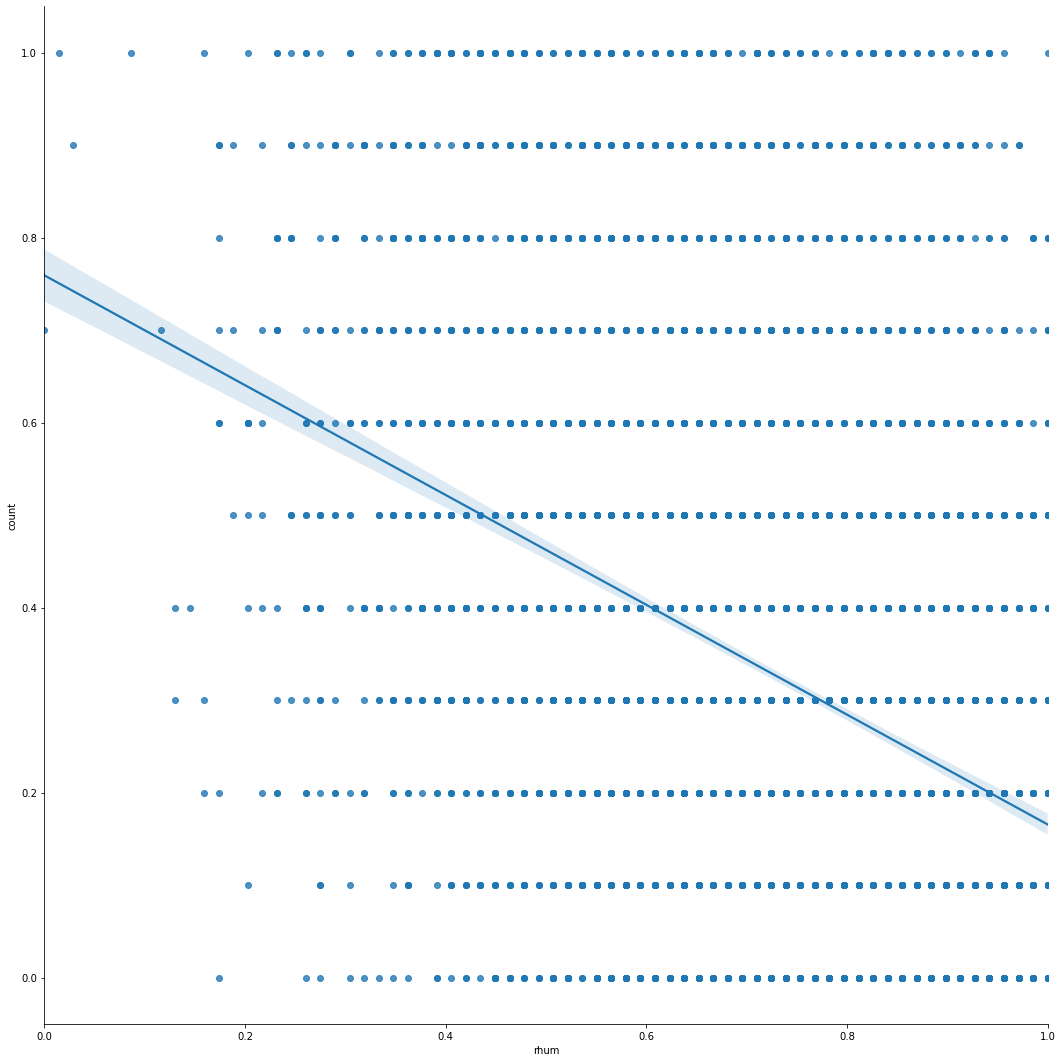

In [92]:
sns.pairplot(scaled_features_df, 
             x_vars=['rhum'],
            #  x_vars=['temp','rain','wdsp','rhum'],
             dropna=True, 
             y_vars='count', height=15, kind="reg", palette='Set1')
plt.show()

In [27]:
scaled_features_df.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
temp,0.139296,-0.403309
rain,11.508617,215.575746
wdsp,0.960073,1.310869
rhum,-0.677497,0.129054


In [28]:
normalized_numerical_data.temp.agg(['skew', 'kurtosis']).transpose()

skew        0.139296
kurtosis   -0.403309
Name: temp, dtype: float64

## Log transformation

The logarithmic is a strong transformation that has a major effect on distribution shape. This technique is, as the square root method, oftenly used for reducing right skewness. Worth noting, however, is that it can not be applied to zero or negative values.

## Square Root
The square root method is typically used when your data is moderately skewed. Now using the square root (e.g., sqrt(x)) is  a transformation that has a moderate effect on distribution shape. It is generally used to reduce right skewed data. Finally, the square root can be applied on zero values and is most commonly used on counted data.

## Box Cox Transformation
The Box-Cox transformation is, as you probably understand, also a technique to transform non-normal data into normal shape. This is a procedure to identify a suitable exponent (Lambda = l) to use to transform skewed data.

In [ ]:
fig = plt.figure(figsize=(22,6))
gs = fig.add_gridspec(1, 3)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

sns.histplot(scaled_features_df['rain'],ax=ax0, kde=True)
sns.histplot(scaled_features_df['wdsp'],ax=ax1, kde=True)
sns.histplot(scaled_features_df['rhum'],ax=ax2, kde=True)

ax0.set(xlabel='Rain', ylabel='Count',title="Distribution - Rain")
ax1.set(xlabel='Wind Speed', ylabel='Count',title="Distribution - Wind Speed")
ax2.set(xlabel='Relative Humidity', ylabel='Count',title="Distribution - Relative Humidity")

plt.show()

## Target feature (Count)

In [ ]:
transform_data = hourly_data.copy()
transform_data['count'] = np.log(transform_data['count'] + 1)

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
sns.histplot(hourly_data['count'],ax=ax0, kde=True)
sns.histplot(transform_data['count'],ax=ax1, kde=True)
ax0.set(xlabel='Rentals Count',ylabel='Density',title="Distribution - Target Feature (Count)")
ax1.set(xlabel='Rentals Count',ylabel='Density',title="Distribution of Target variable after Log Transformation")
plt.show()

## Outliers Analysis

In [93]:
hourlyDataWithoutOutliers = hourly_data[np.abs(hourly_data["count"]-hourly_data["count"] \
    .mean())<=(2*hourly_data["count"].std())] 

In [ ]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
sns.boxplot(data=hourly_data,y="count",orient="v",ax=ax0)
sns.boxplot(data=hourlyDataWithoutOutliers,y="count",orient="v",ax=ax1)
ax0.set(ylabel='Count',title="Box Plot On Count")
ax1.set(ylabel='Count',title="Box Plot On Count WITHOUT Outliers")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(hourlyDataWithoutOutliers['count'],ax=ax, kde=True)
ax.set(xlabel='Rentals Count',ylabel='Density',title="Distribution - Target Feature (Without Outliers)")
plt.show()

In [ ]:
print ("Shape of original data: ",hourly_data.shape)
print ("Shape of data without outliers: ",hourlyDataWithoutOutliers.shape)

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [29]:
df = hourly_data.copy()
#df = hourlyDataWithoutOutliers.copy()
#df = transform_data.copy()
df = df.astype({'holiday': 'category', 'dayofweek': 'category', 'working_day': 'category', 'peak': 'category'})
predictors = ['holiday','dayofweek','working_day','peak']
numerical_data = df.filter(['rain','temp','wdsp','rhum'], axis=1)

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(numerical_data)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
principalDf.head()

## Testing Linear Regression Assumptions

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
# Returning the R^2 for the model
linear_r2 = pipe_linear_regression.score(X_train, y_train)
print('R^2: {0}'.format(linear_r2))

In [ ]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

## Linearity

In [ ]:
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

In [ ]:
linear_assumption(pipe_linear_regression, X_train, y_train)

## Normality of the Error Terms

In [ ]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.histplot(df_results['Residuals'], kde=True) 
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

In [ ]:
normal_errors_assumption(pipe_linear_regression, X_train, y_train)

## No Multicollinearity among Predictors

In [ ]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

In [ ]:
multicollinearity_assumption(pipe_linear_regression, X_train, y_train)

## No Autocorrelation of the Error Terms

In [ ]:
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [ ]:
autocorrelation_assumption(pipe_linear_regression, X_train, y_train)

## Homoscedasticity

In [ ]:
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show() 

In [ ]:
homoscedasticity_assumption(pipe_linear_regression, X_train, y_train)

## Linear Regression Assumptions Test

# Linear Regression Assumptions

- Linearity
- Normality of the Error
- No Multicollinearity among Predictors
- No Autocorrelation of the Error Terms
- Homoscedasticity

In [ ]:
hourly_data.head()

In [ ]:
def linear_regression_assumptions(features, label, feature_names=None):
    """
    Tests a linear regression on the model to see if assumptions are being met
    """
    from sklearn.linear_model import LinearRegression
    
    # Setting feature names to x1, x2, x3, etc. if they are not defined
    if feature_names is None:
        feature_names = ['X'+str(feature+1) for feature in range(features.shape[1])]
    
    print('Fitting linear regression')
    # Multi-threading if the dataset is a size where doing so is beneficial
    if features.shape[0] < 100000:
        model = LinearRegression(n_jobs=-1)
    else:
        model = LinearRegression()
        
    model.fit(features, label)
    
    # Returning linear regression R^2 and coefficients before performing diagnostics
    r2 = model.score(features, label)
    print()
    print('R^2:', r2, '\n')
    print('Coefficients')
    print('-------------------------------------')
    print('Intercept:', model.intercept_)
    
    for feature in range(len(model.coef_)):
        print('{0}: {1}'.format(feature_names[feature], model.coef_[feature]))

    print('\nPerforming linear regression assumption testing')
    
    # Creating predictions and calculating residuals for assumption tests
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    
    def linear_assumption():
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
        # Plotting the diagonal line
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term')
        
        
    def normal_errors_assumption(p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
               
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        print('\n=======================================================================================')
        print('Assumption 2: The error terms are normally distributed')
        print()
    
        print('Using the Anderson-Darling test for normal distribution')

        # Performing the test on the residuals
        p_value = normal_ad(df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
    
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(df_results['Residuals'])
        plt.show()
    
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
        else:
            print('Assumption not satisfied')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
        
        
    def multicollinearity_assumption():
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        print('\n=======================================================================================')
        print('Assumption 3: Little to no multicollinearity among predictors')
        
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
        plt.title('Correlation of Variables')
        plt.show()
        
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
       
        # Gathering the VIF for each variable
        VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(feature_names[idx], vif))
        
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        print()
        print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
        print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
        print()

        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        
        
    def autocorrelation_assumption():
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson
        print('\n=======================================================================================')
        print('Assumption 4: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(df_results['Residuals'])
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')

            
    def homoscedasticity_assumption():
        """
        Homoscedasticity: Assumes that the errors exhibit constant variance
        """
        print('\n=======================================================================================')
        print('Assumption 5: Homoscedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
        plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroscedasticity is apparent, confidence intervals and predictions will be affected')
        
        
    linear_assumption()
    normal_errors_assumption()
    multicollinearity_assumption()
    autocorrelation_assumption()
    homoscedasticity_assumption()

In [ ]:
df = hourly_data.copy()
#df = hourlyDataWithoutOutliers.copy()
#df = transform_data.copy()
df = df.astype({'holiday': 'category', 
                'dayofweek': 'category', 
                'working_day': 'category', 
                'peak': 'category', 
                'timesofday': 'category'})
predictors = ['rain','temp','wdsp','rhum','holiday','dayofweek','working_day','peak','timesofday']

X = df[[c for c in df.columns if c in predictors]]
y = df.pop('count')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

In [ ]:
num_vars = [n for n in df.select_dtypes(include=['number']).columns if n in predictors] # list comprehension to select only predictors features
cat_vars = [c for c in df.select_dtypes(include=['category']).columns if c in predictors]

In [ ]:
num_vars, cat_vars

In [ ]:
test = pd.get_dummies(df['timesofday'])
test.head()

In [ ]:
linear_regression_assumptions(features=X_train,label=y_train)

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini